In [28]:
import sys
import os

sys.path.insert(0, os.path.abspath('../'))

import CtllDes 
from CtllDes.core import ctll, satellite


In [29]:
import matplotlib.pyplot as plt
plt.style.use("classic")
#import seaborn as sns
import numpy as np
import pandas as pd
import astropy as astr
import astropy.units as u
import astropy

In [30]:
from poliastro.bodies import Earth, Sun
from poliastro.frames import Planes
from poliastro.constants import J2000
from poliastro.ephem import Ephem

# Define a function using poliastro utilities in order to obtain the sun-earth vector
this could be added to the library if needed, but I don't think is appropriate since every utility comes from poliastro and astropy libraries.

# Defining specifications and parameters constraints

## <strong>Instruments</strong>

In [31]:
import CtllDes.core.instrument as instr

In [32]:
ROLL_ANGLE = 30*u.deg

### 1st instrument

In [33]:
pixel_width_1 = 28*1E-6*u.m
n_pixels_1 = 3072
sensor_width_1 = n_pixels_1*pixel_width_1
f_length_1 = 17*1E-2*u.m

In [34]:
instr_1 = instr.RollPushBroom(f_length_1, sensor_width_1, ROLL_ANGLE)

### 2nd instrument 

In [35]:
pixel_width_2 = 7*1E-6*u.m
n_pixels_2 = 12288
sensor_width_2 = n_pixels_2*pixel_width_2
f_length_2 = 0.42*u.m

In [36]:
instr_2 = instr.RollPushBroom(f_length_2, sensor_width_2, ROLL_ANGLE)

## <strong>Targets</strong>

In [37]:
from CtllDes.targets.targets import Target, Targets

### 1st instrument targets

In [38]:
bs_as = Targets.from_state("Buenos Aires", N=15)
rio_negro = Targets.from_state("Río Negro", N=15)

### 2nd instrument targets

In [39]:
gba = Targets.from_state("Ciudad de Buenos Aires", N=8) 

cordoba_city = Target.from_city('Córdoba', country='AR')
rosario_city = Target.from_city('Rosario', country='AR')

### <strong>Ground Stations</strong>

In [40]:
MIN_ELEVATION = 15*u.deg
DOWN_RATE = 300*1E6*u.bit/u.s

In [41]:
gs_1 = Target(-64.45, -31.58333)
gs_2 = Target(-58.718, -34.411)

In [42]:
min(gba.lats)-max(gba.lats)

-0.1809631983215354

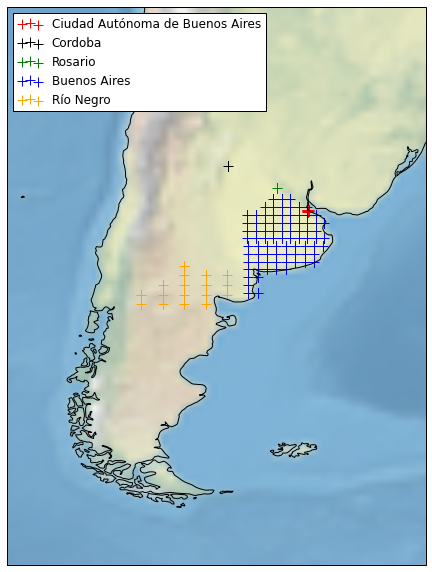

In [43]:
import cartopy.crs as ccrs

%matplotlib inline
fig, ax = plt.subplots(figsize=(20,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

ax.scatter(gba.lons,gba.lats,label='Ciudad Autónoma de Buenos Aires',s=100, marker='+',c='red')
ax.scatter(cordoba_city.lon,cordoba_city.lat,label='Cordoba',s=100, marker='+',c='k')
ax.scatter(rosario_city.lon,rosario_city.lat,label='Rosario',s=100, marker='+',c='green')

ax.scatter(bs_as.lons,bs_as.lats,s=100,label='Buenos Aires', marker='+',c='blue')
ax.scatter(rio_negro.lons,rio_negro.lats,s=100,label='Río Negro', marker='+',c='orange')

ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
ax.set_ylim(-60,-20)
ax.set_xlim(-80,-50)

ax.legend(loc=2)

### <strong>Orbits</strong>

In [44]:
H_MIN = 550*u.km
H_MAX = 650*u.km
MAX_INC = 45*u.deg

R = Earth.R_mean.to(u.km)

R_MIN = R + H_MIN
R_MAX = R + H_MAX

In [45]:
from CtllDes.utils import sscalc

In [46]:
D = 3 #days for revisit
orb_df = sscalc.helio_rgt_synchronous(D) #dataframe
orb_df.head() #radius [km], inclination [degrees], revolutions per day.

radius         inc         N
0  11549.628629  142.101524  7.000000
1  11196.684826  135.067101  7.333333
2  10869.554031  129.657165  7.666667
3  10565.337007  125.300767  8.000000
4  10281.565346  121.693395  8.333333

In [47]:
filtered_orbits = orb_df.loc[(orb_df['radius']>R_MIN.value)&(orb_df['radius']<R_MAX.value)]
filtered_orbits

radius       inc     N
24  6947.854468  97.66328  15.0

### Extract semi major axis length = to radius, and inclination.

In [48]:
a = filtered_orbits['radius'].values[0]
a *= u.km
a

<Quantity 6947.85446754 km>

In [49]:
inc = filtered_orbits['inc'].values[0]
inc *= u.deg
inc

<Quantity 97.66328018 deg>

### Define the rest of the classical orbit parameters

In [50]:
ecc = 0*u.one # eccentricity
raan = 0*u.deg # right ascencion of the ascending node [angle]
argp = 0*u.rad # perigee argument [angle]
nu = 0*u.deg # true anomaly [angle] defined as -180 so that it coincides with LTDN

### Build orbit

In [51]:
from poliastro.twobody import Orbit

orb = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            raan,
                            argp,
                            nu)

In [52]:
print(orb.r)
print(orb.v)

[6947.85446754    0.            0.        ] km
[ 0.         -1.01004329  7.50667069] km / s


In [53]:
sat = satellite.Sat.from_orbit(orb)

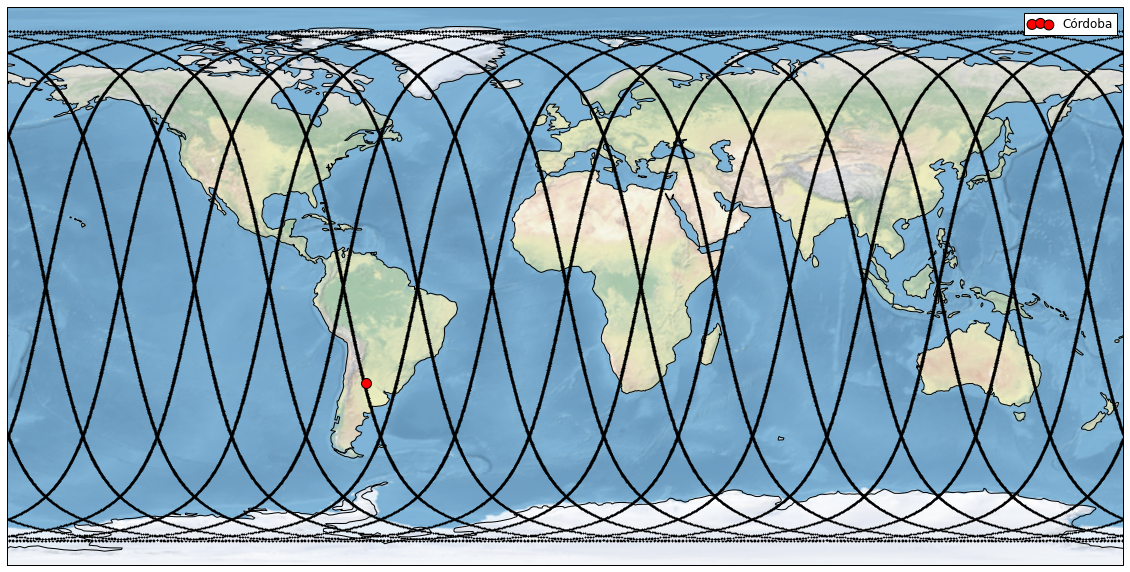

In [54]:
r,v = sat.rv(10,dt=10,J2=True)
lon,lat = sat.ssps_from_r(r, 10, dt=10, J2=True)

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

ax.scatter(lon.to(u.deg),lat.to(u.deg),s=0.4,c='k')
ax.scatter(cordoba_city.lon, cordoba_city.lat, label='Córdoba', c='r', s=100)
ax.legend(loc=1)

Lets redefine the angle such that LTDN is 12 o'clock solar time 

In [55]:
from CtllDes.utils import trigsf, angles

today = astropy.time.Time({'year':2021,'month':12,'day':31,'hour':12}, scale='utc')
earth_orb = Ephem.from_body(Sun, today.tdb, attractor=Earth)


r0_sun = earth_orb.rv()[0][0].to(u.km)
rr0_sun, lat0_sun, lon0_sun = trigsf.c2s(r0_sun[0],r0_sun[1],r0_sun[2])
lon0_sun.to(u.deg)

<Quantity -79.42945987 deg>

### So the initial raan of the satellite orbit must be such that when $\theta_p+\nu=180\text{°}$ the longitude value in the inertial reference frame is exactly the same as the sun. Therefore

In [56]:
argp = 0*u.deg
nu = 179.9999*u.deg - argp

orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
r0_sat = orb.r
rr0_sat, lat0_sat, lon0_sat = trigsf.c2s(r0_sat[0],r0_sat[1],r0_sat[2])
lon0_sat.to(u.deg)

<Quantity -179.99998666 deg>

### Naturally the initial longitude, if raan is 0 must be the exactly $\nu$, therefore modifying raan by $lon(sun_0)-180°$ we get

In [57]:
raan = lon0_sun-180*u.deg
orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
new_r0_sat = orb.r
_, _, lon0_sat = trigsf.c2s(new_r0_sat[0],new_r0_sat[1],new_r0_sat[2])
lon0_sat.to(u.deg)

<Quantity -79.42944654 deg>

In [58]:
#this has to change names, is not passage raan, is passage offset. 
sat = satellite.Sat.from_orbit(orb)
cordoba_offset = angles.get_passage_raan(sat, (cordoba_city.lon*u.deg).to(u.rad),(cordoba_city.lat*u.deg).to(u.rad))+180*u.deg

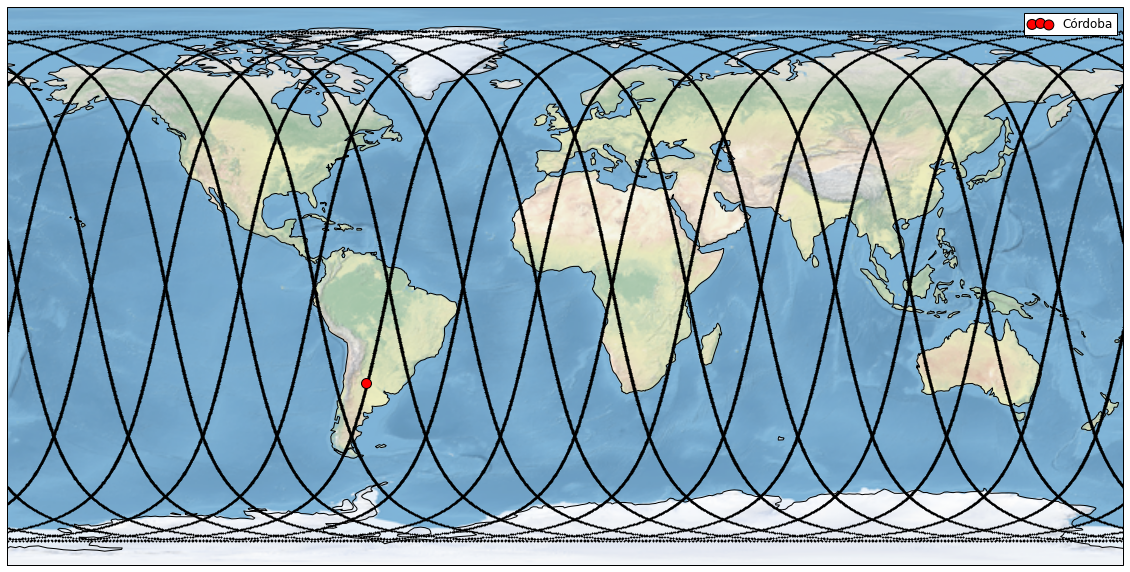

In [59]:
sat = satellite.Sat.from_orbit(orb)
r,v = sat.rv(10,dt=10,J2=True)
lon,lat = sat.ssps_from_r(r,10,dt=10,lon_offset=cordoba_offset,J2=True)

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

ax.scatter(lon.to(u.deg),lat.to(u.deg),s=0.4,c='k')
ax.scatter(cordoba_city.lon, cordoba_city.lat, label='Córdoba', c='r', s=100)
ax.legend(loc=1)

## Definitive first reference satm. Instrument 2 Constellation 

In [60]:
ctll_hrgt = ctll.Ctll.from_WalkerDelta(4, 2, 0, orb.a, orb.ecc, orb.inc, orb.argp, raan_offset=orb.raan, nu_offset=nu, instruments=instr_2)

In [61]:
from CtllDes.requests.coverage import Coverages 

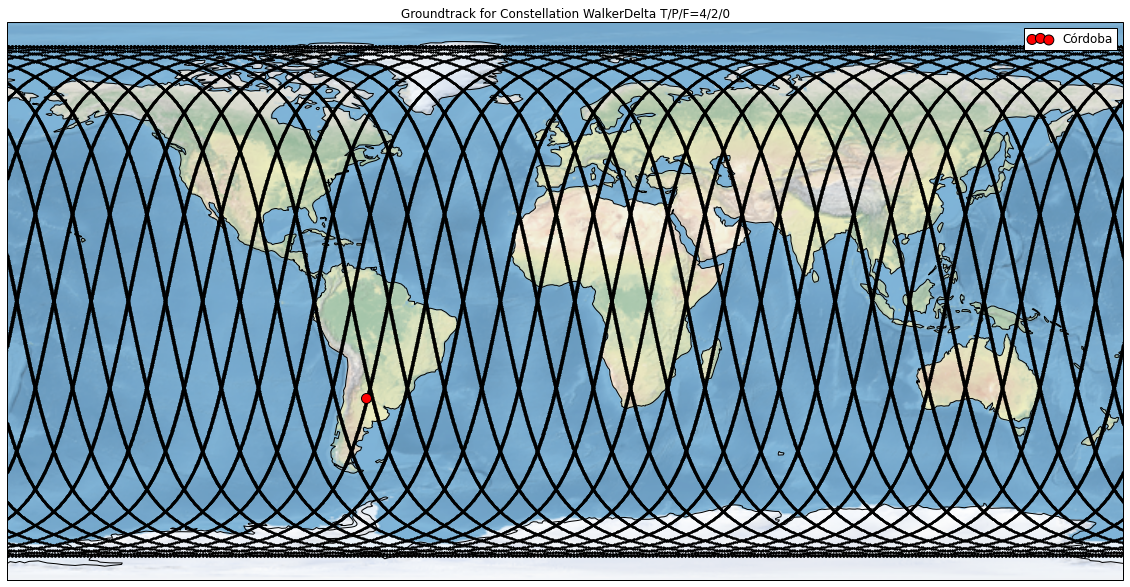

In [62]:
fig, ax = plt.subplots(figsize=(20,10))


ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

for _ in ctll_hrgt.sats:
    r,v =  _.rv(10, dt=10, J2=True)
    lon,lat = _.ssps_from_r(r,10,dt=10,lon_offset=cordoba_offset,J2=True)

    ax.scatter(lon.to(u.deg),lat.to(u.deg),s=0.4,c='k')
    
    
ax.scatter(cordoba_city.lon, cordoba_city.lat, label='Córdoba', c='r', s=100)
ax.set_title("Groundtrack for Constellation WalkerDelta T/P/F=4/2/0")
ax.legend(loc=1)

## Define time of study and time interval, i.e T=10, dt=20

In [63]:
T=10
ti=35

In [64]:
from CtllDes.utils import sunearth

In [65]:
rsun = sunearth.bodies_vector(T, ti, Earth, Sun, epoch=today)

### Coverages over all targets

In [ ]:
cov_cordoba = Coverages.from_ctll(ctll_hrgt, cordoba_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)
cov_rosario = Coverages.from_ctll(ctll_hrgt, rosario_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

cov_baires = Coverages.from_ctll(ctll_hrgt, bs_as, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)
cov_rio_negro = Coverages.from_ctll(ctll_hrgt, rio_negro, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)
cov_gba = Coverages.from_ctll(ctll_hrgt, gba, T, ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

### Tricontourf without filtering data

Text(0.5, 1.0, 'Mean Revisit Time over Buenos Aires and Río Negro')

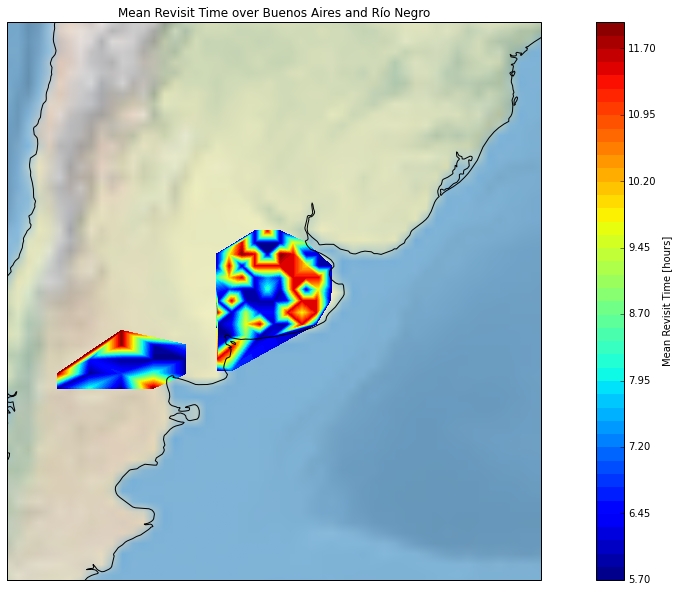

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())

tcs = ax.tricontourf(bs_as.lons, bs_as.lats, cov_baires.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())
#tcs = ax.tripcolor(bs_as.lons, bs_as.lats, cov_baires.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree(),  shading='gouraud')
cb = plt.colorbar(tcs)
cb.ax.set_ylabel("Mean Revisit Time [hours]")

tcs = ax.tricontourf(rio_negro.lons, rio_negro.lats, cov_rio_negro.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())
#tcs = ax.tripcolor(rio_negro.lons, rio_negro.lats, cov_rio_negro.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree(), shading='gouraud')

ax.coastlines()
ax.stock_img()

ax.set_xlim(min(bs_as.lons)-10, max(bs_as.lons)+10)
ax.set_ylim(min(bs_as.lats)-10, max(bs_as.lats)+10)
ax.set_title("Mean Revisit Time over Buenos Aires and Río Negro")        

### Filtering data from sun angle

In [ ]:
f_cov_cordoba = cov_cordoba.filter_by_sun_angle(np.pi/4)
f_cov_rosario = cov_rosario.filter_by_sun_angle(np.pi/4)

f_cov_baires = cov_baires.filter_by_sun_angle(np.pi/4)
f_cov_rio_negro = cov_rio_negro.filter_by_sun_angle(np.pi/4)
f_cov_gba = cov_gba.filter_by_sun_angle(np.pi/4)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())

tcs = ax.tricontourf(bs_as.lons, bs_as.lats, f_cov_baires.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())
cb = plt.colorbar(tcs)
cb.ax.set_ylabel("Mean Revisit Time [hours]")

tcs = ax.tricontourf(rio_negro.lons, rio_negro.lats, f_cov_rio_negro.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())


ax.coastlines()
#ax.stock_img()

ax.set_xlim(min(bs_as.lons)-10, max(bs_as.lons)+10)
ax.set_ylim(min(bs_as.lats)-10, max(bs_as.lats)+10)
ax.set_title("Mean Revisit Time over Buenos Aires and Río Negro")        

# Build-Up Analysis for Helio-RGT constellation

In [ ]:
def cov_matrix(constellation, labels, cov_dfs, key='mean gap dark'):
    
    ids = constellation.sats_id
    
    df = pd.DataFrame(index=ids, columns=labels)
    
    for i in range(len(ids)):
        for j in range(len(labels)):
            tmp_mean_total = np.mean(cov_dfs[j].collapse_sats().to_df()[key].to_numpy()/3600)
            tmp_mean_partial = np.mean(cov_dfs[j].collapse_sats([ids[k] for k in range(len(ids)) if k != i ]).to_df()[key].to_numpy()/3600)
            df.iloc[i][j] = tmp_mean_partial - tmp_mean_total
    
    return df

In [ ]:
revisit_time_matrix = cov_matrix(ctll_hrgt, ['Córdoba', 'Rosario', 'Bs. As.', 'Río Negro', 'CABA'],
          [f_cov_cordoba, f_cov_rosario, f_cov_baires, f_cov_rio_negro, f_cov_gba])

response_time_matrix = cov_matrix(ctll_hrgt, ['Córdoba', 'Rosario', 'Bs. As.', 'Río Negro', 'CABA'],
                          [f_cov_cordoba, f_cov_rosario, f_cov_baires, f_cov_rio_negro, f_cov_gba],
                          key= 'response time')


In [ ]:
revisit_time_matrix

In [ ]:
response_time_matrix

# Complete Constellation with Instrument 1 Satellite

In [ ]:
orb_ctll_li_1 = Orbit.from_classical(Earth, a, ecc, 45*u.deg, 129.39*u.deg, argp, nu)

In [ ]:
sat_1_li = satellite.Sat.from_orbit(orb_ctll_li_1, instruments=instr_1)

In [ ]:
ctll_li = ctll.Ctll.from_sats(ctll_hrgt.sats + [sat_1_li], pattern=[{'PAT':'Full Constellation', 'N':5}])

## Groundtrack

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))


ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-5, central_longitude=-60))
ax.coastlines()
ax.stock_img()

for _ in ctll_li.sats:
    r,v =  _.rv(10, dt=5, J2=True)
    lon,lat = _.ssps_from_r(r,10,dt=5,lon_offset=cordoba_offset,J2=True)

    ax.scatter(lon.to(u.deg),lat.to(u.deg),s=0.4,c='k', transform=ccrs.PlateCarree())
    
    
ax.set_title("Groundtrack for Constellation WalkerDelta T/P/F=4/2/0")


## Coverage Analysis

In [ ]:
cov_cordoba_ctll_li = Coverages.from_ctll(ctll_li, cordoba_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)
cov_rosario_ctll_li = Coverages.from_ctll(ctll_li, rosario_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

cov_gba_ctll_li = Coverages.from_ctll(ctll_li, gba, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)
cov_baires_ctll_li = Coverages.from_ctll(ctll_li, bs_as, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)
cov_rio_negro_ctll_li = Coverages.from_ctll(ctll_li, rio_negro, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

proj=ccrs.Orthographic(central_longitude=-60,central_latitude=-30)
ax = plt.axes(projection=proj)
ax.set_global()

tcs = ax.tricontourf(bs_as.lons, bs_as.lats, cov_baires_ctll_li.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())
cb = plt.colorbar(tcs)
cb.ax.set_ylabel("Mean Revisit Time [hours]")

tcs = ax.tricontourf(rio_negro.lons, rio_negro.lats, cov_rio_negro_ctll_li.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())

ax.coastlines()
ax.stock_img()

ax.set_title("Mean Revisit Time over Buenos Aires and Río Negro")        

In [ ]:
f_cov_cordoba_ctll_li = cov_cordoba_ctll_li.filter_by_sun_angle(np.pi/4)
f_cov_rosario_ctll_li = cov_rosario_ctll_li.filter_by_sun_angle(np.pi/4)

f_cov_baires_ctll_li = cov_baires_ctll_li.filter_by_sun_angle(np.pi/4)
f_cov_rio_negro_ctll_li = cov_rio_negro_ctll_li.filter_by_sun_angle(np.pi/4)
f_cov_gba_ctll_li = cov_gba_ctll_li.filter_by_sun_angle(np.pi/4)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())

tcs = ax.tricontourf(bs_as.lons, bs_as.lats, f_cov_baires_ctll_li.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())
#tcs = ax.tripcolor(bs_as.lons, bs_as.lats, cov_baires.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree(),  shading='gouraud')
cb = plt.colorbar(tcs)
cb.ax.set_ylabel("Mean Revisit Time [hours]")

tcs = ax.tricontourf(rio_negro.lons, rio_negro.lats, f_cov_rio_negro_ctll_li.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree())
#tcs = ax.tripcolor(rio_negro.lons, rio_negro.lats, cov_rio_negro.collapse_sats().to_df()['mean gap dark']/3600, 60, transform=ccrs.PlateCarree(), shading='gouraud')

ax.coastlines()
ax.stock_img()

ax.set_xlim(min(bs_as.lons)-10, max(bs_as.lons)+10)
ax.set_ylim(min(bs_as.lats)-10, max(bs_as.lats)+10)
ax.set_title("Mean Revisit Time over Buenos Aires and Río Negro")        

# Build Up Analysis Full Constellation

In [ ]:
revisit_time_matrix = cov_matrix(ctll_li, ['Córdoba', 'Rosario', 'Bs. As.', 'Río Negro', 'CABA'],
          [f_cov_cordoba_ctll_li, f_cov_rosario_ctll_li, f_cov_baires_ctll_li, f_cov_rio_negro_ctll_li, f_cov_gba_ctll_li])

response_time_matrix = cov_matrix(ctll_li, ['Córdoba', 'Rosario', 'Bs. As.', 'Río Negro', 'CABA'],
                          [f_cov_cordoba_ctll_li, f_cov_rosario_ctll_li, f_cov_baires_ctll_li, f_cov_rio_negro_ctll_li, f_cov_gba_ctll_li],
                          key= 'response time')

avg_time_matrix = cov_matrix(ctll_li, ['Córdoba', 'Rosario', 'Bs. As.', 'Río Negro', 'CABA'],
                          [f_cov_cordoba_ctll_li, f_cov_rosario_ctll_li, f_cov_baires_ctll_li, f_cov_rio_negro_ctll_li, f_cov_gba_ctll_li],
                          key= 'average time gap')

In [ ]:
revisit_time_matrix

In [ ]:
response_time_matrix

In [ ]:
avg_time_matrix

# Orbit Degradation analysis 

In [359]:
m1 = []
m2 = []
m3 = []
m4 = []
m5 = []
r1 = []
r2 = []
r3 = []
r4 = []
r5 = []

for alpha in [0.999, 0.998, 0.997, 0.996, 0.995, 0.994, 0.993, 0.992, 0.991, 0.990]:
    
    tmp_ctll_hrgt = ctll.Ctll.from_WalkerDelta(4, 2, 0, orb.a*alpha, orb.ecc, orb.inc, orb.argp, raan_offset=orb.raan, nu_offset=nu, instruments=instr_2)
    
    tmp_orb_ctll_li_1 = Orbit.from_classical(Earth, a, ecc, 45*u.deg, 129.39*u.deg, argp, nu)
    tmp_sat_1_li = satellite.Sat.from_orbit(tmp_orb_ctll_li_1, instruments=instr_1)

    tmp_ctll_li = ctll.Ctll.from_sats(tmp_ctll_hrgt.sats + [tmp_sat_1_li], pattern=[{'PAT':'Low inclination', 'N':2}])
    
    tmp_cov_cordoba_ctll_li = Coverages.from_ctll(tmp_ctll_li, cordoba_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)
    tmp_cov_rosario_ctll_li = Coverages.from_ctll(tmp_ctll_li, rosario_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

    tmp_cov_gba_ctll_li = Coverages.from_ctll(ctll_li, gba, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=False, J2=True)
    tmp_cov_baires_ctll_li = Coverages.from_ctll(ctll_li, bs_as, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=False, J2=True)
    tmp_cov_rio_negro_ctll_li = Coverages.from_ctll(ctll_li, rio_negro, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=False, J2=True)

    cov1 = tmp_cov_cordoba_ctll_li.filter_by_sun_angle(np.pi/4)
    cov2 = tmp_cov_rosario_ctll_li.filter_by_sun_angle(np.pi/4)
    cov3 = tmp_cov_gba_ctll_li.filter_by_sun_angle(np.pi/4)
    cov4 = tmp_cov_baires_ctll_li.filter_by_sun_angle(np.pi/4)
    cov5 = tmp_cov_rio_negro_ctll_li.filter_by_sun_angle(np.pi/4)

    mr1 = np.mean(cov1.collapse_sats().to_df()['mean gap dark'].to_numpy(dtype=np.float64))
    mr2 = np.mean(cov2.collapse_sats().to_df()['mean gap dark'].to_numpy(dtype=np.float64))
    mr3 = np.mean(cov3.collapse_sats().to_df()['mean gap dark'].to_numpy(dtype=np.float64))
    mr4 = np.mean(cov4.collapse_sats().to_df()['mean gap dark'].to_numpy(dtype=np.float64))
    mr5 = np.mean(cov5.collapse_sats().to_df()['mean gap dark'].to_numpy(dtype=np.float64))
    
    rt1 = np.mean(cov1.collapse_sats().to_df()['response time'].to_numpy(dtype=np.float64))
    rt2 = np.mean(cov2.collapse_sats().to_df()['response time'].to_numpy(dtype=np.float64))
    rt3 = np.mean(cov3.collapse_sats().to_df()['response time'].to_numpy(dtype=np.float64))
    rt4 = np.mean(cov4.collapse_sats().to_df()['response time'].to_numpy(dtype=np.float64))
    rt5 = np.mean(cov5.collapse_sats().to_df()['response time'].to_numpy(dtype=np.float64))
    
    
    m1.append(mr1)
    m2.append(mr2)
    m3.append(mr3)
    m4.append(mr4)
    m5.append(mr5)

    r1.append(rt1)
    r2.append(rt2)
    r3.append(rt3)
    r4.append(rt4)
    r5.append(rt5)
    
    
    print(f"{alpha} has finished")
    

0.999 has finished
0.998 has finished
0.997 has finished
0.996 has finished
0.995 has finished
0.994 has finished
0.993 has finished
0.992 has finished
0.991 has finished
0.99 has finished


Text(0, 0.5, 'Response Time [h]')

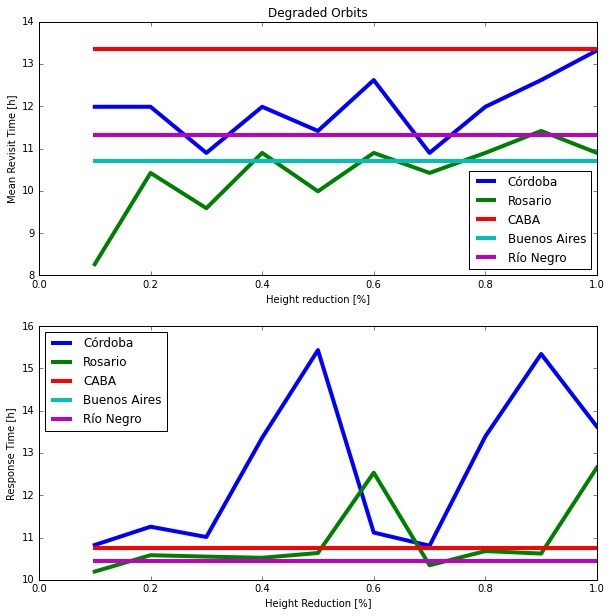

In [362]:
fig, ax = plt.subplots(nrows=2,figsize=(10,10))
alphas=(1-np.array([0.999, 0.998, 0.997, 0.996, 0.995, 0.994, 0.993, 0.992, 0.991, 0.990]))*100

ax[0].plot(alphas, np.array(m1)/3600, linewidth=4, label='Córdoba')
ax[0].plot(alphas, np.array(m2)/3600, linewidth=4, label='Rosario')
ax[0].plot(alphas, np.array(m3)/3600, linewidth=4, label='CABA')
ax[0].plot(alphas, np.array(m4)/3600, linewidth=4, label='Buenos Aires')
ax[0].plot(alphas, np.array(m5)/3600, linewidth=4, label='Río Negro')
ax[0].legend(loc=4)
ax[0].set_title("Degraded Orbits")
ax[0].set_xlabel("Height reduction [%]")
ax[0].set_ylabel("Mean Revisit Time [h]")

ax[1].plot(alphas, np.array(r1)/3600, linewidth=4, label='Córdoba')
ax[1].plot(alphas, np.array(r2)/3600, linewidth=4, label='Rosario')
ax[1].plot(alphas, np.array(r3)/3600, linewidth=4, label='CABA')
ax[1].plot(alphas, np.array(r4)/3600, linewidth=4, label='Buenos Aires')
ax[1].plot(alphas, np.array(r5)/3600, linewidth=4, label='Río Negro')
ax[1].legend(loc=2)

ax[1].set_xlabel("Height Reduction [%]")
ax[1].set_ylabel("Response Time [h]")

# Ground Stations

In [ ]:
benavidez = Target(-58.718, -34.411)
FDC = Target(-64.43, -31.5833)

In [ ]:
desired_comm_data_benavidez = comm.default_comm_data(desired_sat, benavidez, T, dt=ti, J2=True)
desired_comm_data_FDC = comm.default_comm_data(desired_sat, FDC, T, dt=ti, J2=True)

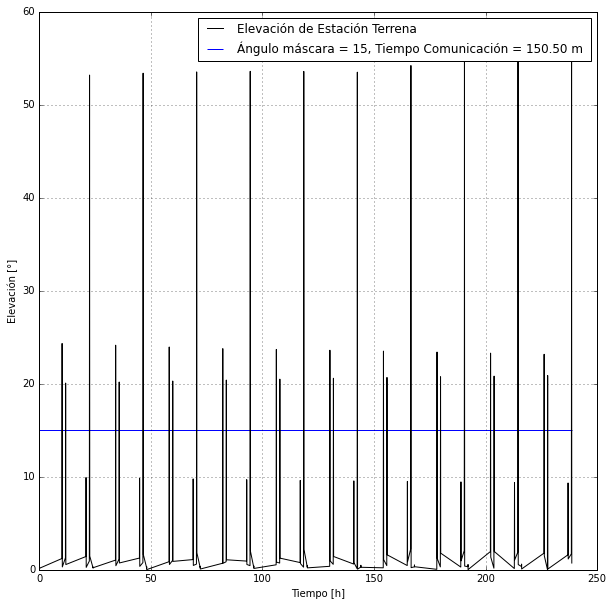

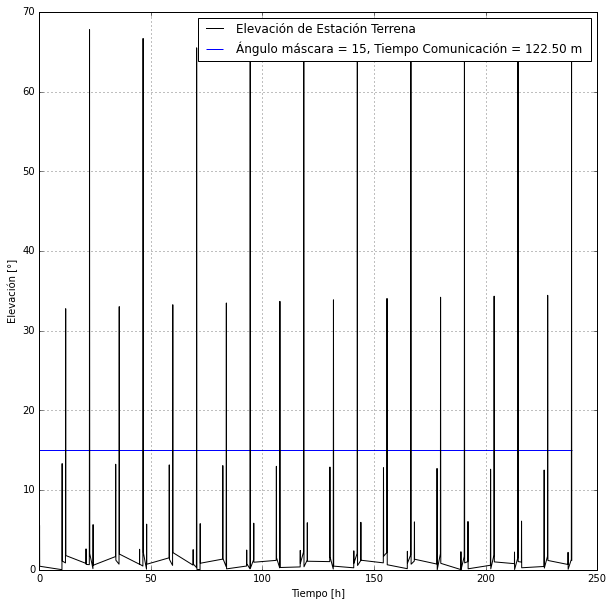

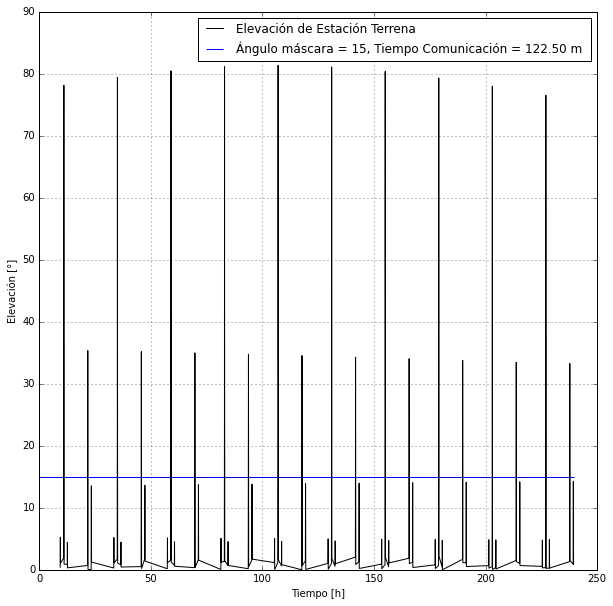

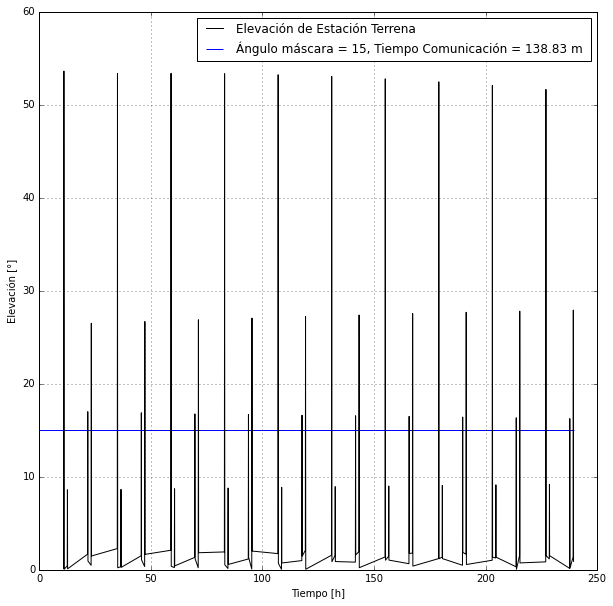

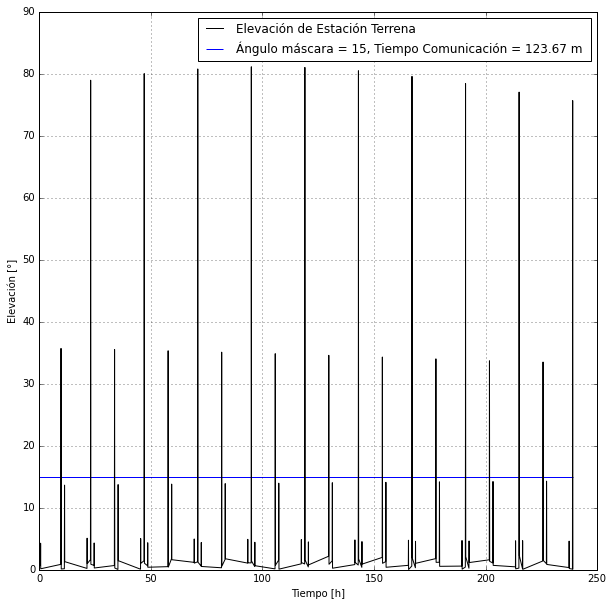

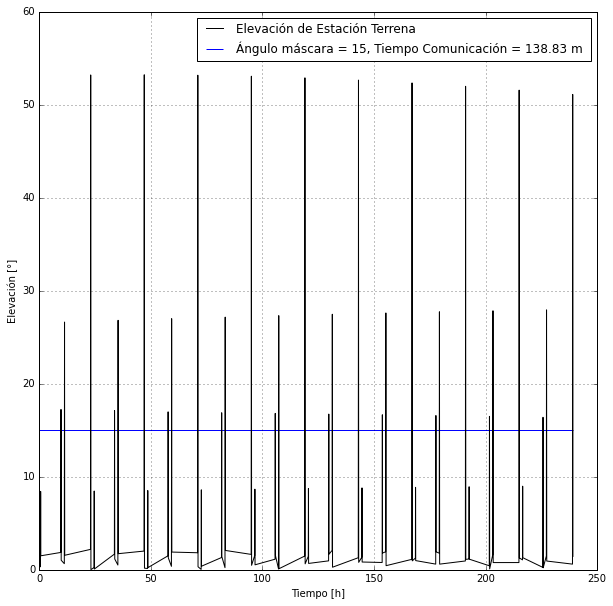

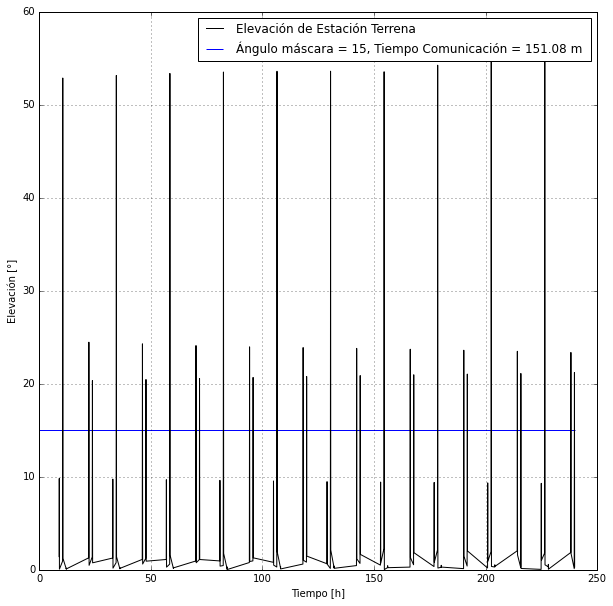

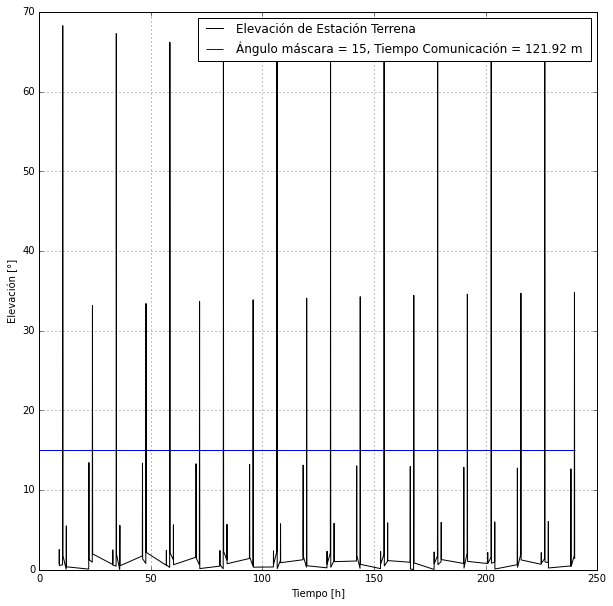

In [103]:
%matplotlib inline
for _ in ctll_hrgt.sats:
    desired_benavidez = comm.default_comm_data(_, benavidez, T, dt=ti, J2=True)
    desired_FDC = comm.default_comm_data(_, FDC, T, dt=ti, J2=True)
    plot_comm(desired_benavidez, mask=15, deg=True, total_time=True)
    plot_comm(desired_FDC, mask=15, deg=True, total_time=True)

In [94]:
def plot_comm(comm_df, mask = None, deg=False, total_time=False):
    """Plot Communicatoin data.
    
    Parameters
    ----------
    comm_df : pandas.DataFrame
        Output of CtllDes.requests.comm.default_comm_data(...) 
    mask : float
        Minimum angle required to establish communication
    deg : boolean, optional
        set to degrees, if mask is used it must match the unit used.
    total_time : bollean, optional
        report in figure legend total time over ground station.
    """
    
    if not deg:
        elevation = comm_df['elevation'].to_numpy(dtype=np.float64)
    else:
        elevation = comm_df['elevation'].to_numpy(dtype=np.float64)*180/np.pi
    
    time = comm_df['time']/3600
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(time, elevation, linewidth=1, color='black', label='Elevación de Estación Terrena')
    ax.grid()
    if mask != None:
        elevation_mask = [e for e in elevation if e > mask]
        time_over = len(elevation_mask)*(time[1]-time[0])*3600 #very nasty

        if not deg:
            ax.hlines(mask, xmin=0, xmax=max(time), label=f'Ángulo máscara = {mask}, Tiempo Comunicación = {time_over/60:.2f} m')
        else:
            ax.hlines(mask, xmin=0, xmax=max(time),label=f'Ángulo máscara = {mask}, Tiempo Comunicación = {time_over/60:.2f} m ')
            
    ax.set_xlabel("Tiempo [h]")
    if not deg:
        ax.set_ylabel("Elevación [rad]")
    else:
        ax.set_ylabel("Elevación [°]")        
    
    ax.legend(loc=1)